In [1]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


Original shape: (2154048, 19)
Inactive churn dropped: 299279
Shape after cleaning: (1854769, 19)
Shape after drop useless: (1854769, 16)
[TOP_PACK] Rare packs merged: 58

[PACK_GROUP] Final distribution:
PACK_GROUP
NO_PACK         603324
VOICE_ALLNET    384957
DATA_PACK       360442
VOICE_ONNET     321942
COMBO_PACK       67512
DAILY_PACK       57279
SOCIAL_PACK      48710
WEEKLY_PACK       5754
OTHER_PACK        3115
WIFI_PACK          651
MONTHLY_PACK       512
RARE_PACK          432
EVC_PACK           139
Name: count, dtype: int64

Categorical features: ['REGION', 'TENURE', 'PACK_GROUP']

Training CatBoost...
0:	test: 0.9373654	best: 0.9373654 (0)	total: 1.19s	remaining: 23m 44s
200:	test: 0.9448518	best: 0.9448518 (200)	total: 2m 59s	remaining: 14m 54s
400:	test: 0.9454150	best: 0.9454150 (400)	total: 6m 2s	remaining: 12m 1s
600:	test: 0.9454887	best: 0.9454917 (532)	total: 9m 6s	remaining: 9m 4s
800:	test: 0.9454587	best: 0.9454917 (532)	total: 12m 14s	remaining: 6m 5s
1000:	test:

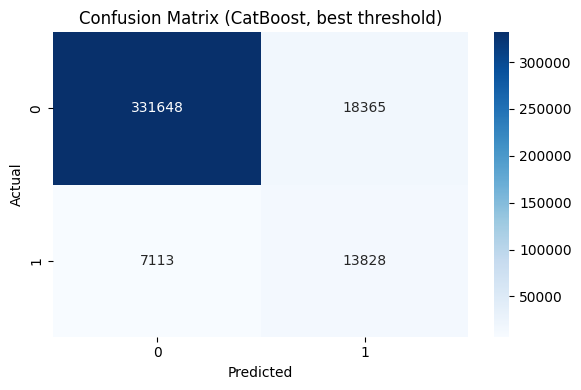

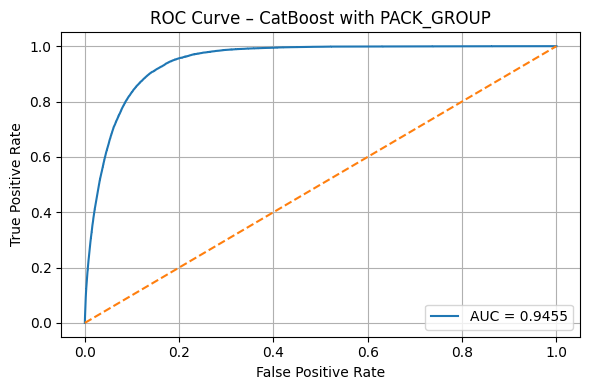

In [2]:
# =============================================================================
# 0. IMPORT
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    accuracy_score
)

from catboost import CatBoostClassifier, Pool

pd.set_option('display.float_format', '{:.3f}'.format)


# =============================================================================
# 1. FUNCTION: CLEAN + STANDARDIZE TOP_PACK
# =============================================================================
def prepare_top_pack(
    df,
    col_name="TOP_PACK",
    rare_threshold=50,
    new_clean_col="TOP_PACK_CLEAN",
    new_group_col="PACK_GROUP"
):
    """Clean + standardize TOP_PACK into PACK_GROUP."""

    df[col_name] = df[col_name].fillna("no_pack")
    top_pack_str = df[col_name].astype(str).str.strip()
    df[new_clean_col] = top_pack_str.copy()

    # Rare handling for TOP_PACK
    pack_counts = df[new_clean_col].value_counts()
    rare_packs = pack_counts[pack_counts < rare_threshold].index
    df[new_clean_col] = df[new_clean_col].where(
        ~df[new_clean_col].isin(rare_packs),
        "RARE_PACK"
    )

    print(f"[TOP_PACK] Rare packs merged: {len(rare_packs)}")

    # Group mapping
    def pack_group(x):
        s = str(x).lower()

        if s == "no_pack": return "NO_PACK"
        if "rare_pack" in s: return "RARE_PACK"
        if any(k in s for k in ["data:", "gprs", "mifi", "internet"]): return "DATA_PACK"
        if "wifi" in s: return "WIFI_PACK"
        if any(k in s for k in ["on net", "on-net", "onnet"]): return "VOICE_ONNET"
        if any(k in s for k in ["all-net", "all net", "allnet"]): return "VOICE_ALLNET"
        if any(k in s for k in ["mixt", "mix ", "combo"]): return "COMBO_PACK"
        if any(k in s for k in ["jokko", "ymgx", "youth", "facebook", "social"]): return "SOCIAL_PACK"
        if any(k in s for k in ["24h", "1day", "daily"]): return "DAILY_PACK"
        if any(k in s for k in ["weekly", "7d", "week"]): return "WEEKLY_PACK"
        if any(k in s for k in ["monthly", "30d", "month"]): return "MONTHLY_PACK"
        if "evc_" in s: return "EVC_PACK"
        if any(k in s for k in ["fifa", "sport"]): return "SPORT_PACK"
        if any(k in s for k in ["vas(", "ivr", "radio", "crbt", "telmun"]): return "VAS_PACK"

        return "OTHER_PACK"

    df[new_group_col] = df[new_clean_col].apply(pack_group)

    # Rare PACK_GROUP
    group_counts = df[new_group_col].value_counts()
    rare_groups = group_counts[group_counts < 50].index
    df[new_group_col] = df[new_group_col].where(
        ~df[new_group_col].isin(rare_groups),
        "OTHER_PACK"
    )

    print("\n[PACK_GROUP] Final distribution:")
    print(df[new_group_col].value_counts())

    return df


# =============================================================================
# 2. LOAD DATA
# =============================================================================
df = pd.read_csv("/kaggle/input/expresso-churn-prediction-challenge/Train.csv")
print("Original shape:", df.shape)


# =============================================================================
# 3. DROP INACTIVE CHURN
# =============================================================================
usage_cols = ["MONTANT", "REVENUE", "ON_NET", "ORANGE", "TIGO", "ZONE1", "ZONE2"]
usage_sum = df[usage_cols].fillna(0).sum(axis=1)

inactive_mask = (usage_sum == 0) & (df["CHURN"] == 1)
print("Inactive churn dropped:", inactive_mask.sum())

df = df[~inactive_mask].copy()
print("Shape after cleaning:", df.shape)


# =============================================================================
# 4. DROP USELESS COLUMNS
# =============================================================================
drop_cols = [c for c in ["ARPU_SEGMENT", "MRG", "user_id"] if c in df.columns]
df = df.drop(columns=drop_cols)
print("Shape after drop useless:", df.shape)


# =============================================================================
# 5. HANDLE MISSING VALUES
# =============================================================================
df["REGION"] = df["REGION"].fillna("unknown")

extra_numeric_cols = ["FREQUENCE_RECH", "FREQUENCE", "DATA_VOLUME", "FREQ_TOP_PACK"]
for col in usage_cols + extra_numeric_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)


# =============================================================================
# 6. CLEAN TOP_PACK → PACK_GROUP
# =============================================================================
df = prepare_top_pack(df)


# =============================================================================
# 7. CONVERT SAFE FLOAT TO INT
# =============================================================================
def convert_float(df_):
    for col in df_.select_dtypes(include="float").columns:
        if (df_[col].dropna() == np.floor(df_[col].dropna())).all():
            df_[col] = df_[col].astype("Int64")
    return df_

df = convert_float(df)


# =============================================================================
# 8. CATBOOST USES RAW CATEGORICALS → NO LABEL ENCODING NEEDED
# =============================================================================
categorical_cols = ["REGION", "TENURE", "PACK_GROUP"]

print("\nCategorical features:", categorical_cols)

# Remove only RAW TOP_PACK strings
df = df.drop(columns=["TOP_PACK", "TOP_PACK_CLEAN"])


# =============================================================================
# 9. TRAIN / TEST SPLIT
# =============================================================================
df.dropna(subset=['CHURN'], inplace=True)
X = df.drop("CHURN", axis=1)
y = df["CHURN"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# CatBoost Pool
train_pool = Pool(X_train, y_train, cat_features=categorical_cols)
test_pool = Pool(X_test, y_test, cat_features=categorical_cols)


# =============================================================================
# 10. TRAIN CATBOOST MODEL
# =============================================================================
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    learning_rate=0.05,
    depth=8,
    n_estimators=1200,
    l2_leaf_reg=3,
    random_seed=42,
    verbose=200,
    class_weights=[1, 5]    # imbalance handling (churn is minority)
)

print("\nTraining CatBoost...")
cat_model.fit(train_pool, eval_set=test_pool)
print("Training done.")


# =============================================================================
# 11. THRESHOLD OPTIMIZATION (maximize F1)
# =============================================================================
y_prob = cat_model.predict_proba(test_pool)[:, 1]

best_th = 0.5
best_f1 = 0.0

for t in np.linspace(0.01, 0.99, 300):
    y_temp = (y_prob >= t).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_temp).ravel()

    prec = tp / (tp + fp + 1e-8)
    rec  = tp / (tp + fn + 1e-8)
    f1   = 2 * prec * rec / (prec + rec + 1e-8)

    if f1 > best_f1:
        best_f1 = f1
        best_th = t

print("\n===== BEST CATBOOST THRESHOLD ===telek=")
print("Threshold:", best_th)
print("Best F1:", best_f1)


# =============================================================================
# 12. FINAL EVALUATION
# =============================================================================
y_pred = (y_prob >= best_th).astype(int)

print("\n=== CATBOOST FINAL REPORT ===")
print(classification_report(y_test, y_pred))

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", auc)


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (CatBoost, best threshold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – CatBoost with PACK_GROUP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
!pip install shap


Calculating SHAP values...


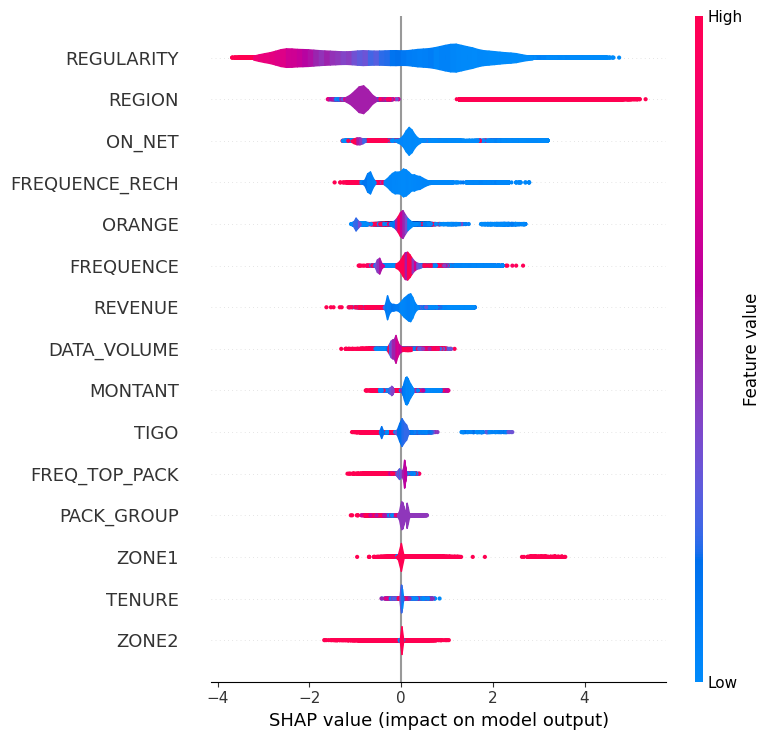


Top features by mean(|SHAP|):
           feature  importance
12      REGULARITY       1.432
0           REGION       1.266
7           ON_NET       0.425
3   FREQUENCE_RECH       0.318
8           ORANGE       0.243
5        FREQUENCE       0.243
4          REVENUE       0.207
6      DATA_VOLUME       0.200
2          MONTANT       0.159
9             TIGO       0.118
13   FREQ_TOP_PACK       0.075
14      PACK_GROUP       0.070
10           ZONE1       0.035
1           TENURE       0.023
11           ZONE2       0.019


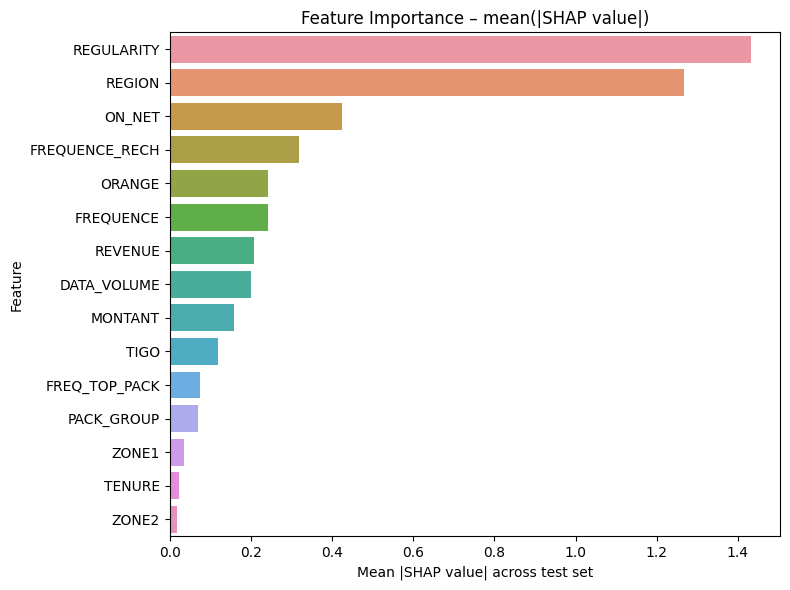

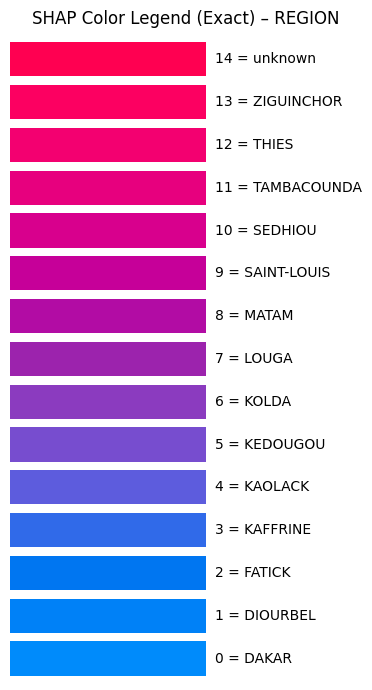

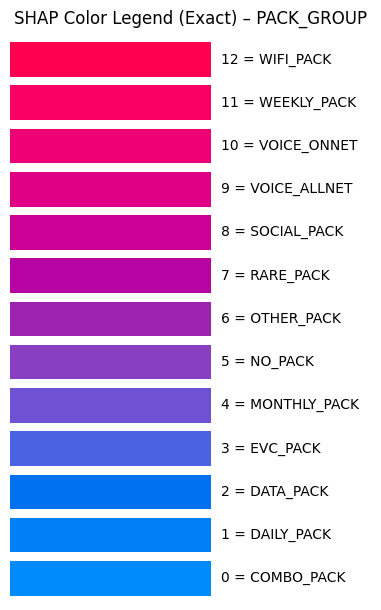

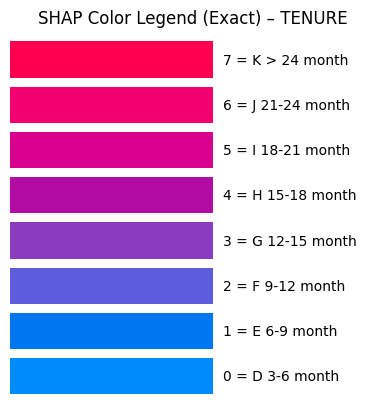

In [4]:
# =============================================================================
# 13. SHAP VALUES + SUMMARY PLOT
# =============================================================================
import shap

print("\nCalculating SHAP values...")

# Get SHAP values from CatBoost (n_samples x (n_features + 1))
shap_values = cat_model.get_feature_importance(
    data=test_pool,
    type="ShapValues"
)

# Separate SHAP matrix and expected value
shap_values_matrix = shap_values[:, :-1]
expected_value = shap_values[:, -1]

feature_names = X_train.columns.tolist()

# Build numeric-only version of X_test for SHAP plotting
X_display = X_test.copy()
for col in X_display.columns:
    # object → category codes
    if X_display[col].dtype == "object":
        X_display[col] = X_display[col].astype("category").cat.codes
    # pandas nullable Int64 → float
    if str(X_display[col].dtype).startswith("Int"):
        X_display[col] = X_display[col].astype(float)

# SHAP summary plot (violin)
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_matrix,
    X_display,
    feature_names=feature_names,
    plot_type="violin",
    max_display=20
)


# =============================================================================
# 14. FEATURE IMPORTANCE DIAGRAM (mean |SHAP|)
# =============================================================================
shap_importance = np.abs(shap_values_matrix).mean(axis=0)

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": shap_importance
}).sort_values("importance", ascending=False)

print("\nTop features by mean(|SHAP|):")
print(fi_df.head(20))

plt.figure(figsize=(8, 6))
sns.barplot(
    data=fi_df.head(20),
    x="importance",
    y="feature"
)
plt.title("Feature Importance – mean(|SHAP value|)")
plt.xlabel("Mean |SHAP value| across test set")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# =============================================================================
# CORRECT SHAP COLOR LEGEND (same colormap as SHAP summary)
# =============================================================================
import numpy as np
import matplotlib.pyplot as plt
from shap.plots._utils import colors   # SHAP internal colormap

def shap_category_legend_correct(X_original, col_name):
    """
    Tạo legend màu CATEGORY khớp 100% với thang màu trong SHAP summary plot.
    X_original: X_test trước khi encode
    col_name: tên biến categorical (REGION, PACK_GROUP,...)
    """

    # Lấy categories theo đúng thứ tự .cat.codes
    cats = X_original[col_name].astype("category").cat.categories
    n = len(cats)

    if n == 0:
        print(f"No categories in {col_name}")
        return

    # === Colormap nội bộ của SHAP ===
    shap_cmap = colors.red_blue  # CHÍNH XÁC 100% colormap SHAP summary dùng

    # Codes tương ứng 0..n-1
    codes = np.arange(n, dtype=float)

    # Chuẩn hoá codes để map vào colormap SHAP
    if n > 1:
        norm_codes = (codes - codes.min()) / (codes.max() - codes.min())
    else:
        norm_codes = np.array([0.5])

    # Lấy màu từ colormap SHAP
    colors_list = [shap_cmap(v) for v in norm_codes]

    # === Vẽ legend ===
    fig, ax = plt.subplots(figsize=(4, 0.4 * n + 1))
    for i, (code, cat_label, color) in enumerate(zip(codes, cats, colors_list)):
        ax.barh(y=i, width=1.0, color=color)
        ax.text(1.05, i, f"{int(code)} = {cat_label}", va="center", fontsize=10)

    ax.set_ylim(-0.5, n - 0.5)
    ax.set_xlim(0, 1.8)
    ax.axis("off")
    ax.set_title(f"SHAP Color Legend (Exact) – {col_name}", pad=10)
    plt.tight_layout()
    plt.show()

for col in ["REGION", "PACK_GROUP", "TENURE"]:
    shap_category_legend_correct(X_test, col)

